In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/kaggle

'kaggle (1).json'


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle/kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hassan06/nslkdd

Dataset URL: https://www.kaggle.com/datasets/hassan06/nslkdd
License(s): unknown
  0% 0.00/13.9M [00:00<?, ?B/s]
100% 13.9M/13.9M [00:00<00:00, 1.74GB/s]


In [ ]:
!unzip nslkdd.zip -d nslkdd

Archive:  nslkdd.zip
  inflating: nslkdd/KDDTest+.arff    
  inflating: nslkdd/KDDTest+.txt     
  inflating: nslkdd/KDDTest-21.arff  
  inflating: nslkdd/KDDTest-21.txt   
  inflating: nslkdd/KDDTest1.jpg     
  inflating: nslkdd/KDDTrain+.arff   
  inflating: nslkdd/KDDTrain+.txt    
  inflating: nslkdd/KDDTrain+_20Percent.arff  
  inflating: nslkdd/KDDTrain+_20Percent.txt  
  inflating: nslkdd/KDDTrain1.jpg    
  inflating: nslkdd/index.html       
  inflating: nslkdd/nsl-kdd/KDDTest+.arff  
  inflating: nslkdd/nsl-kdd/KDDTest+.txt  
  inflating: nslkdd/nsl-kdd/KDDTest-21.arff  
  inflating: nslkdd/nsl-kdd/KDDTest-21.txt  
  inflating: nslkdd/nsl-kdd/KDDTest1.jpg  
  inflating: nslkdd/nsl-kdd/KDDTrain+.arff  
  inflating: nslkdd/nsl-kdd/KDDTrain+.txt  
  inflating: nslkdd/nsl-kdd/KDDTrain+_20Percent.arff  
  inflating: nslkdd/nsl-kdd/KDDTrain+_20Percent.txt  
  inflating: nslkdd/nsl-kdd/KDDTrain1.jpg  
  inflating: nslkdd/nsl-kdd/index.html  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

In [ ]:
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty_level'
]

train_df = pd.read_csv("nslkdd/KDDTrain+.txt", names=column_names)
train_df.to_csv("nslkdd/KDDTrain+.csv", index=False)
test_df=pd.read_csv("nslkdd/KDDTest+.txt", names=column_names)
test_df.to_csv("nslkdd/KDDTest+.csv", index=False)


In [ ]:
x_train=train_df.drop(['label','difficulty_level'],axis=1)
y_train=train_df['label']
x_test=test_df.drop(['label','difficulty_level'],axis=1)
y_test=test_df['label']

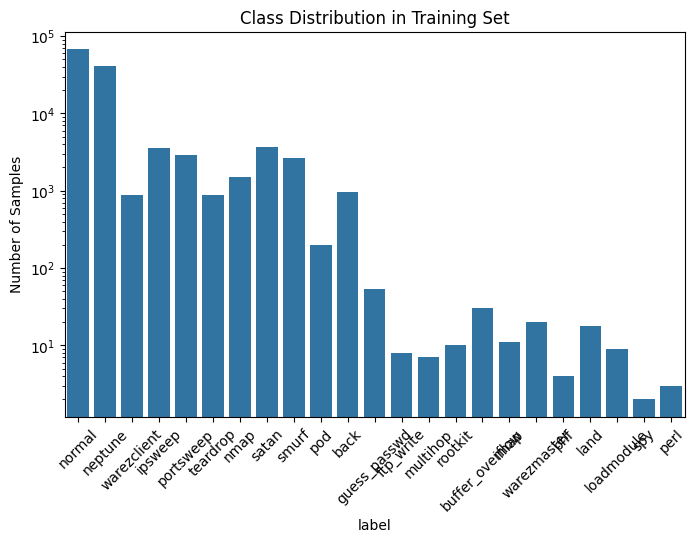

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
# Summary statistics of network traffic features
print(train_df.describe())

           duration     src_bytes     dst_bytes           land  \
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000   
mean      287.14465  4.556674e+04  1.977911e+04       0.000198   
std      2604.51531  5.870331e+06  4.021269e+06       0.014086   
min         0.00000  0.000000e+00  0.000000e+00       0.000000   
25%         0.00000  0.000000e+00  0.000000e+00       0.000000   
50%         0.00000  4.400000e+01  0.000000e+00       0.000000   
75%         0.00000  2.760000e+02  5.160000e+02       0.000000   
max     42908.00000  1.379964e+09  1.309937e+09       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   125973.000000  125973.000000  125973.000000      125973.000000   
mean         0.022687       0.000111       0.204409           0.001222   
std          0.253530       0.014366       2.149968           0.045239   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000       0.00000

In [ ]:
x_train_encoded = x_train.copy()
x_test_encoded = x_test.copy()

enc_protocol = LabelEncoder()
enc_service = LabelEncoder()
enc_flag = LabelEncoder()

x_train_encoded['protocol_type'] = enc_protocol.fit_transform(x_train['protocol_type'])
x_train_encoded['service'] = enc_service.fit_transform(x_train['service'])
x_train_encoded['flag'] = enc_flag.fit_transform(x_train['flag'])

x_test_encoded['protocol_type'] = enc_protocol.transform(x_test['protocol_type'])
x_test_encoded['service'] = enc_service.transform(x_test['service'])
x_test_encoded['flag'] = enc_flag.transform(x_test['flag'])


le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_test_enc = y_test.map(lambda x: le_y.transform([x])[0] if x in le_y.classes_ else -1)#Unseen labels in training set but present in test set are ignored
mask = y_test_enc != -1
x_test_filtered = x_test_encoded[mask]
y_test_filtered = y_test_enc[mask]

In [ ]:
clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

clf.fit(x_train_encoded, y_train_enc)
y_pred = clf.predict(x_test_filtered)
print("Test Accuracy:", accuracy_score(y_test_filtered, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:06:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.8655954027881239


In [ ]:
print("Multi Class Classification Report:\n")
print(classification_report(y_test_filtered, y_pred))

Multi Class Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       359
           1       1.00      0.05      0.10        20
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00      1231
           4       0.00      0.00      0.00         1
           5       0.99      0.99      0.99       141
           6       1.00      0.57      0.73         7
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        18
           9       1.00      1.00      1.00      4657
          10       0.96      1.00      0.98        73
          11       0.81      0.98      0.89      9711
          12       0.25      0.50      0.33         2
          13       1.00      0.50      0.67         2
          14       0.72      0.95      0.82        41
          15       0.79      0.92      0.85       157
          16       0.00      0.00      0.00  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

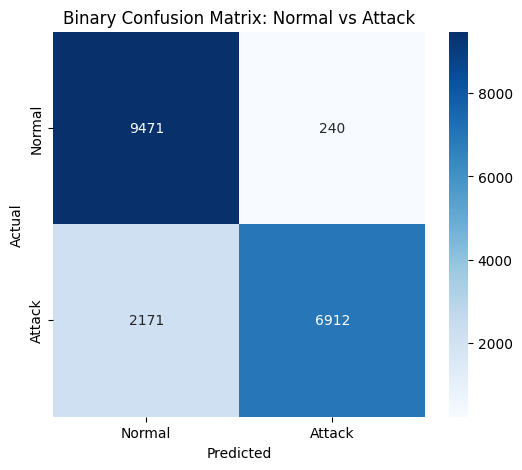

Binary Test Accuracy: 0.871714376928807
Binary Classification Report:
               precision    recall  f1-score   support

      Normal       0.81      0.98      0.89      9711
      Attack       0.97      0.76      0.85      9083

    accuracy                           0.87     18794
   macro avg       0.89      0.87      0.87     18794
weighted avg       0.89      0.87      0.87     18794



In [ ]:
y_test_binary = np.where(y_test_filtered == le_y.transform(['normal'])[0], 0, 1)
y_pred_binary = np.where(y_pred == le_y.transform(['normal'])[0], 0, 1)

# Confusion matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6,5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.title("Binary Confusion Matrix: Normal vs Attack")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Binary Test Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("Binary Classification Report:\n",classification_report(y_test_binary, y_pred_binary, target_names=['Normal','Attack']))


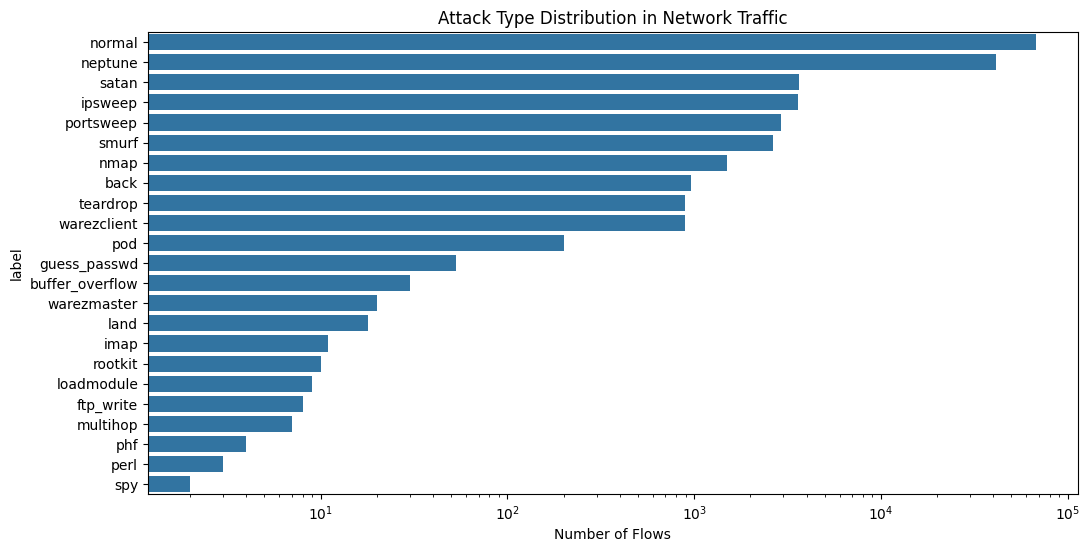

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title("Attack Type Distribution in Network Traffic")
plt.xlabel("Number of Flows")
plt.xscale('log')
plt.show()

/tmp/ipython-input-3765711930.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=names, palette="viridis")


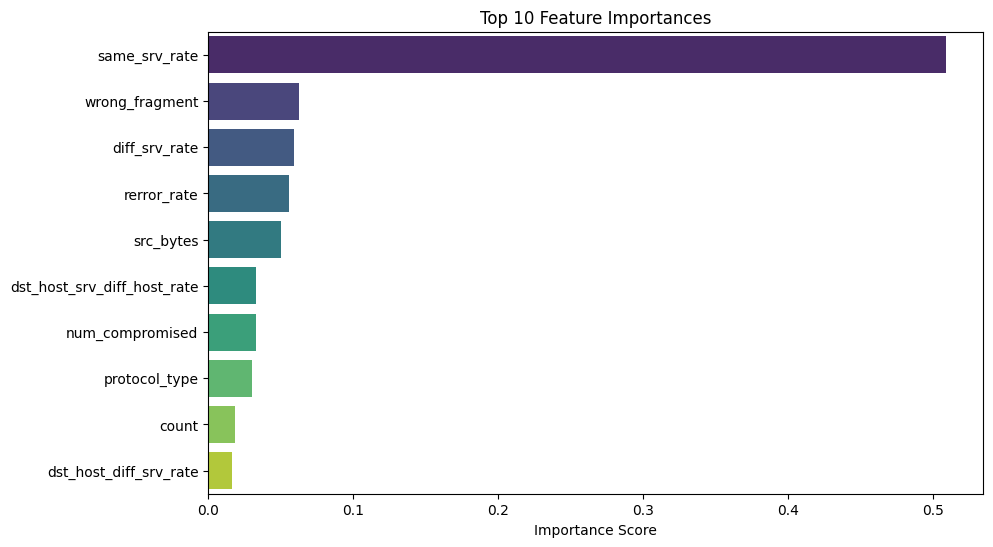

In [ ]:
importances = clf.feature_importances_
feat_names = x_train_encoded.columns
feat_imp = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)[:10]

names, scores = zip(*feat_imp)
plt.figure(figsize=(10,6))
sns.barplot(x=scores, y=names, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
# Creating a table showing the top 10 network features affecting anomaly detection, based on importance score
network_features = pd.DataFrame({
    'Feature': [
        'same_srv_rate', 'wrong_fragment', 'diff_srv_rate', 'rerror_rate',
        'src_bytes', 'dst_host_srv_diff_host_rate', 'num_compromised',
        'protocol_type', 'count', 'dst_host_diff_srv_rate'
    ],
    'Network Feature Description': [
        'Proportion of connections to the same service',
        'Number of wrong fragments in the connection',
        'Proportion of connections to different services',
        'Rate of failed connections or requests',
        'Data volume sent by the host',
        'Rate of connections to different hosts for the same service',
        'Number of compromised conditions',
        'Type of protocol (TCP/UDP/ICMP)',
        'Number of connections from a host',
        'Proportion of connections to different services at the destination host'
    ],

    'Importance': [round(score, 3) for score in scores] #from the previous cell
})

network_features


,Feature,Network Feature Description,Importance
0,same_srv_rate,Proportion of connections to the same service,0.509
1,wrong_fragment,Number of wrong fragments in the connection,0.063
2,diff_srv_rate,Proportion of connections to different services,0.059
3,rerror_rate,Rate of failed connections or requests,0.056
4,src_bytes,Data volume sent by the host,0.050
5,dst_host_srv_diff_host_rate,Rate of connections to different hosts for the...,0.033
6,num_compromised,Number of compromised conditions,0.033
7,protocol_type,Type of protocol (TCP/UDP/ICMP),0.030
8,count,Number of connections from a host,0.018
9,dst_host_diff_srv_rate,Proportion of connections to different service...,0.017


In [ ]:
import joblib

joblib.dump(clf, "xgb_nslkdd_model.pkl")

['xgb_nslkdd_model.pkl']

In [ ]:
from google.colab import files
files.download("xgb_nslkdd_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>